# Env reward scaling - pettingzoo w/ MADDPG

Ensures standard MADDPG works w/ my fold-change reward scaling scheme

Scales using MovingFoldChangeReward. 

### Background
In Dualer models I put reward and intrinsic rewards in competition. This means the two values must be matched up. Or put another way, that need to have common units. There are many ways to do that. Let's consider a biological motivated approach to reward normalization inspired by:

    - Adler, M., and Alon, U. (2018). Fold-change detection in biological
    systems. Current Opinion in Systems Biology 8, 81–89.
    - Karin, O., and Alon, U. (2021). The dopamine circuit as a reward-taxis navigation system. BioRxiv 439955, 30.

We'll try several `envs`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gym
from gym.spaces import Box
import numpy as np
import torch 

from copy import deepcopy
from collections import defaultdict

import pettingzoo
from pettingzoo import mpe
import supersuit as ss
from supersuit import clip_actions_v0

from infoduel_maddpg.utils.buffer import ReplayBuffer
from infoduel_maddpg.core import MADDPG

from infoduel_maddpg.utils.academic_wrappers import StatePrediction
from infoduel_maddpg.utils.normalize_wrappers import ClipReward
from infoduel_maddpg.utils.normalize_wrappers import MovingFoldChangeReward

In [3]:
import matplotlib.pyplot as plt 
%matplotlib inline

# Init

In [4]:
env_name = "simple_v2"
# env_name = "simple_tag_v2"

In [5]:
seed = 50
n_episodes = 25000 # 25000
episode_length = 25
batch_size = 1024
steps_per_update = 100
do_fold = False
do_clip = False
init_noise_scale = 0.3
final_noise_scale = 0.0
n_exploration_eps = n_episodes

# Init Env

In [6]:
Env = getattr(mpe, env_name)
env = Env.parallel_env(continuous_actions=True)
env = clip_actions_v0(env)

# Fold-change?
if do_fold:
    env  = MovingFoldChangeReward(
        env, 
        intial_reference_reward=-1, 
        bias_reward=0, 
        # buffer_size=100, # debug 
        buffer_size=n_episodes//10
    )
# Clip?
if do_clip:
    env = ClipReward(env, min_reward=-100, max_reward=100)

# Init policy

In [7]:
# Make access to 'space' info in format that is
# expected through the codebase
action_space = [env.action_space(a) for a in env.possible_agents]
observation_space = [env.observation_space(a) for a in env.possible_agents]

maddpg = MADDPG.init_from_env(
    env,
    agent_alg="MADDPG",
    adversary_alg="MADDPG",
    tau=0.01,
    lr=0.01,
    hidden_dim=64,
)
replay_buffer = ReplayBuffer(
    n_episodes,
    maddpg.nagents,
    [obsp.shape[0] for obsp in observation_space],
    [acsp.shape[0] if isinstance(acsp, Box) else acsp.n for acsp in action_space],
)

## Run

In [8]:
from tqdm import tqdm

In [9]:
print(f"----- Running: {env_name} ------")
print(f"device: cpu")
# print(f"log_dir: {log_dir}")

total_rewards = []
for n in tqdm(range(n_episodes)):
    # print(f"Episodes {n + 1}-{n + 2} of {n_episodes}")

    # --- Rollout prep
    obs = env.reset()
    maddpg.prep_rollouts(device="cpu")
    
    # Explore (noise) decreases as we go.... 
    explr_pct_remaining = (
            max(0, n_exploration_eps - n) / n_exploration_eps
        )
    maddpg.scale_noise(
        final_noise_scale
        + (init_noise_scale - final_noise_scale) * explr_pct_remaining
    )
    maddpg.reset_noise()

    # --- do Rollout
    for t in range(episode_length):

        # If there are no agents the env
        # should be restarted.
        if len(env.agents) == 0:
            obs = env.reset()

        # rearrange observations for maddpg
        torch_obs = [
            torch.tensor(obs[a], requires_grad=False).unsqueeze(0)
            for a in env.possible_agents
        ]
        # Agents act 'at once' (as parallelized AEC)
        torch_agent_actions = maddpg.step(torch_obs, explore=True)
        # rearrange actions for zoo environment
        agent_actions = {}
        for a, ac in zip(env.possible_agents, torch_agent_actions):
            # The env will only accept 'env.possible_agents',
            # so we filter out the dead
            if a in env.possible_agents:
                agent_actions[a] = ac.data.numpy().flatten()
        # !
        next_obs, rewards, dones, infos = env.step(agent_actions)
        replay_buffer.push(
            [obs[a] for a in env.possible_agents],
            [agent_actions[a] for a in env.possible_agents],
            [rewards[a] for a in env.possible_agents],
            [next_obs[a] for a in env.possible_agents],
            [dones[a] for a in env.possible_agents],
        )

        # setup for next step
        obs = next_obs
        t += 1

        # --- Train (ugly code)?
        if (
            len(replay_buffer) >= batch_size
            and (t % steps_per_update) == 1
        ):
            maddpg.prep_training(device="cpu")
            for a_i, a_n in enumerate(env.possible_agents):
                sample = replay_buffer.sample(batch_size, "cpu")
                maddpg.update(sample, a_i, a_n, logger=None)
            maddpg.update_all_targets()
            maddpg.prep_rollouts(device="cpu")
    
    # -- Log (ep)
    episode_reward = replay_buffer.get_average_rewards(episode_length)
    total_rewards.append(deepcopy(episode_reward))

----- Running: simple_v2 ------
device: cpu


  0%|          | 0/25000 [00:00<?, ?it/s]/Users/qualia/anaconda3/envs/py39/lib/python3.9/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
  0%|          | 36/25000 [00:01<09:54, 41.96it/s] /Users/qualia/Code/infoduel_maddpg/infoduel_maddpg/core.py:156: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(curr_agent.critic.parameters(), 0.5)
/Users/qualia/Code/infoduel_maddpg/infoduel_maddpg/core.py:189: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(curr_agent.policy.parameters(), 0.5)
 17%|█▋        | 4322/25000 [02:56<14:28, 23.80it/s]

## Visualize

Text(0, 0.5, 'Reward')

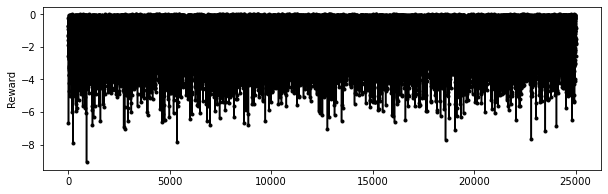

In [33]:
agent = "agent_0"
# total_rewards = np.concatenate(total_rewards)

fig, (ax1) = plt.subplots(1, 1, figsize=(10, 3))
times = np.arange(0, total_rewards.size)
ax1.plot(times, total_rewards, '.-', color="black", label="reward")
if do_fold:
    ax1.axhline(
        env.reference_reward[agent].mean(), 
        color='black', 
        linestyle='dashed', 
        linewidth=2
    )
ax1.set_ylabel("Reward")
# ax1.set_ylim(-10, 10)
# ax2.semilogy()